<a href="https://colab.research.google.com/github/paucaroscanoa/ApiBookAuthor/blob/master/Caso_de_Estudio_5_3_El_filtro_de_Kalman_en_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de Estudio 5.3 - El filtro de Kalman en 3D

**Configuración del *notebook***

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

## Generación de datos

Necesitamos generar de forma sintética mediciones con ruido de la posición del objeto (balón) en 3D. En Python podemos realizar esto de la siguiente manera:

In [2]:
# tamaño de paso temporal
dt = 0.01
# número total de mediciones
m = 200
# posición en el inicio
px= 0.0
py= 0.0
pz= 1.0
# velocidades en el inicio
vx = 5.0
vy = 3.0
vz = 0.0
# Coeficiente de resistencia de arrastre
c = 0.1
# Amortiguación
d = 0.9
# Arrays para almacenar mediciones de posición
Xr=[]
Yr=[]
Zr=[]

# Generando datos
for i in range(0, m):
  # actualizar aceleración (deceleración), velocidad y posición en la dirección x
  accx = -c*vx**2
  vx += accx*dt
  px += vx*dt
  # actualizar aceleración (deceleración), velocidad y posición en la dirección y
  accy = -c*vy**2
  vy += accy*dt
  py += vy*dt
  # actualizar aceleración (deceleración), velocidad y posición en la dirección z
  accz = -9.806 + c*vz**2
  vz += accz*dt
  pz += vz*dt
  # si el objeto está a punto de tocar la base...
  # cambiar dirección con amortiguación
  if pz<0.01:
    vz= -vz*d
    pz+=0.02
  # añadir a las arrays de alamacenamiento de la posición
  Xr.append(px)
  Yr.append(py)
  Zr.append(pz)

# Añadir ruido aleatorio a las mediciones
# Desviación típica para el ruido
sp= 0.1
Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))

# Apilar las mediciones juntas para que sea más fácil manejarlas más adelante
measurements = np.vstack((Xm,Ym,Zm))

Visualización de los datos generados:

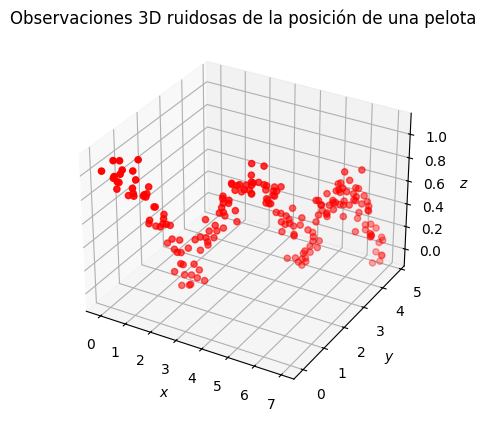

In [3]:
fig = plt.figure()
plot3D = fig.add_subplot(111, projection='3d')
plot3D.scatter(Xm, Ym, Zm, c='red')
plot3D.set_xlabel('$x$')
plot3D.set_ylabel('$y$')
plot3D.set_zlabel('$z$')
plt.title('Observaciones 3D ruidosas de la posición de una pelota')

plt.show()

## Inicialización de variables

Podemos inicializar las variables y matrices que se especifican en el modelo de la siguiente manera:

In [4]:
# Matriz de identidad
I = np.eye(9)
# Matriz de estado
x = np.matrix([0.0, 0.0, 1.0, 5.0, 3.0, 0.0, 0.0, 0.0, -9.81]).T
# Matriz P
P = 100.0*np.eye(9)
# Matriz A
A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0],
               [0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2],
               [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
# Matriz H
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
# Matriz R
r = 1.0
R = np.matrix([[r, 0.0, 0.0],
               [0.0, r, 0.0],
               [0.0, 0.0, r]])

# Matrices Q y G
s = 8.8
G = np.matrix([[1/2.0*dt**2],
               [1/2.0*dt**2],
               [1/2.0*dt**2],
               [dt],
               [dt],
               [dt],
               [1.0],
               [1.0],
               [1.0]])

Q = G*G.T*s**2

## Algoritmo del Filtro de Kalman

In [5]:
# Las siguientes variables guardarán los resultados en cada iteración
xt = []
yt = []
zt = []
dxt= []
dyt= []
dzt= []
ddxt=[]
ddyt=[]
ddzt=[]
Zx = []
Zy = []
Zz = []
Px = []
Py = []
Pz = []
Pdx= []
Pdy= []
Pdz= []
Pddx=[]
Pddy=[]
Pddz=[]
Kx = []
Ky = []
Kz = []
Kdx= []
Kdy= []
Kdz= []
Kddx=[]
Kddy=[]
Kddz=[]

**Algoritmo del Filtro de Kalman**

In [6]:
onFloor = False
for i in range(0, m):
  # Cambio de dirección del modelo cuando se toca la base
  if x[2]<0.02 and not onFloor:
    x[5] = -x[5]
    onFloor=True

  # Predicción
  # Predicción de estado
  x = A*x #+ B*u (B=0 y u=0)
  # Proyectar la covarianza del error hacia adelante
  P = A*P*A.T + Q

  # Actualizar
  # Ganancia de Kalman
  S = H*P*H.T + R
  K = (P*H.T) * np.linalg.pinv(S)
  # Actualizar la estimación via z
  Z = measurements[:,i].reshape(H.shape[0],1)
  y = Z - (H*x)
  x = x + (K*y)
  # Covarianza del error
  P = (I - (K*H))*P

  # Guardar los resultados
  xt.append(float(x[0]))
  yt.append(float(x[1]))
  zt.append(float(x[2]))
  dxt.append(float(x[3]))
  dyt.append(float(x[4]))
  dzt.append(float(x[5]))
  ddxt.append(float(x[6]))
  ddyt.append(float(x[7]))
  ddzt.append(float(x[8]))
  Zx.append(float(Z[0]))
  Zy.append(float(Z[1]))
  Zz.append(float(Z[2]))
  Px.append(float(P[0,0]))
  Py.append(float(P[1,1]))
  Pz.append(float(P[2,2]))
  Pdx.append(float(P[3,3]))
  Pdy.append(float(P[4,4]))
  Pdz.append(float(P[5,5]))
  Pddx.append(float(P[6,6]))
  Pddy.append(float(P[7,7]))
  Pddz.append(float(P[8,8]))
  Kx.append(float(K[0,0]))
  Ky.append(float(K[1,0]))
  Kz.append(float(K[2,0]))
  Kdx.append(float(K[3,0]))
  Kdy.append(float(K[4,0]))
  Kdz.append(float(K[5,0]))
  Kddx.append(float(K[6,0]))
  Kddy.append(float(K[7,0]))
  Kddz.append(float(K[8,0]))


<ipython-input-6-0a7a87efddb0>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xt.append(float(x[0]))
<ipython-input-6-0a7a87efddb0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yt.append(float(x[1]))
<ipython-input-6-0a7a87efddb0>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zt.append(float(x[2]))
<ipython-input-6-0a7a87efddb0>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you e

## Resultados

Estimaciones de estado:

Text(0.5, 0, 'Step')

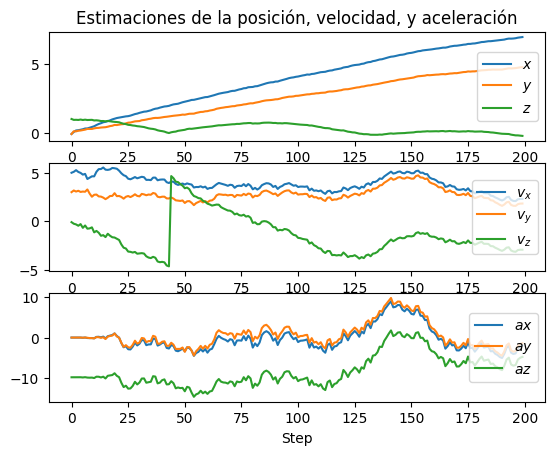

In [7]:
#Estimaciones de estado
plt.subplot(311)
plt.title('Estimaciones de la posición, velocidad, y aceleración')
plt.plot(range(len(measurements[0])),xt, label='$x$')
plt.plot(range(len(measurements[0])),yt, label='$y$')
plt.plot(range(len(measurements[0])),zt, label='$z$')
plt.legend(loc='right' )

plt.subplot(312)
plt.plot(range(len(measurements[0])),dxt, label='$v_x$')
plt.plot(range(len(measurements[0])),dyt, label='$v_y$')
plt.plot(range(len(measurements[0])),dzt, label='$v_z$')
plt.legend(loc='right')

plt.subplot(313)
plt.plot(range(len(measurements[0])),ddxt, label='$ax$')
plt.plot(range(len(measurements[0])),ddyt, label='$ay$')
plt.plot(range(len(measurements[0])),ddzt, label='$az$')
plt.legend(loc='right')
plt.xlabel('Step')

Posición en 2D (z,y):

Text(0, 0.5, '$z$')

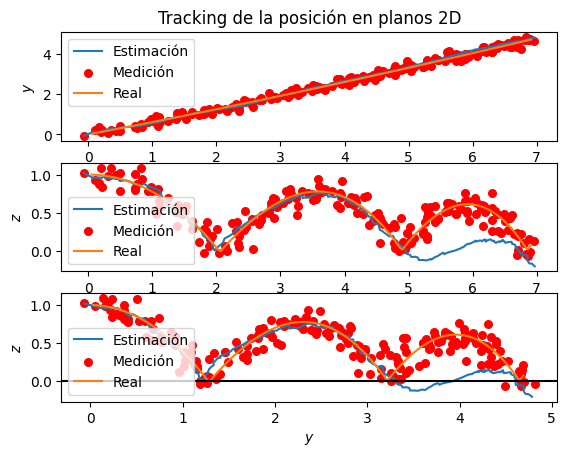

In [8]:
plt.subplot(311)
plt.plot(xt,yt, label='Estimación')
plt.scatter(Xm,Ym, label='Medición', c='red', s=30)
plt.plot(Xr, Yr, label='Real')
plt.title('Tracking de la posición en planos 2D')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.subplot(312)
plt.plot(xt,zt, label='Estimación')
plt.scatter(Xm,Zm, label='Medición', c='red', s=30)
plt.plot(Xr, Zr, label='Real')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$z$')

plt.subplot(313)
plt.plot(yt,zt, label='Estimación')
plt.scatter(Ym,Zm, label='Medición', c='red', s=30)
plt.plot(Yr, Zr, label='Real')
plt.legend(loc='best')
plt.axhline(0, color='k')
plt.xlabel('$y$')
plt.ylabel('$z$')

Posición en 3D (X,Y,Z):

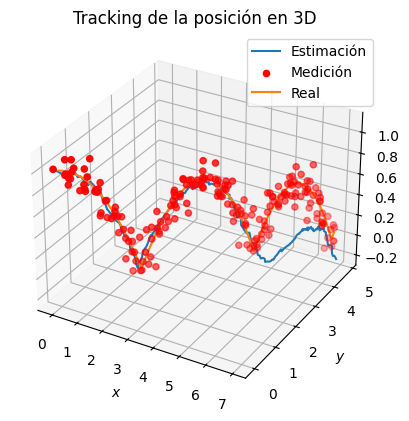

In [9]:
fig = plt.figure()
plot3D = fig.add_subplot(111, projection='3d')
plot3D.plot(xt,yt,zt, label='Estimación')
plot3D.scatter(Xm,Ym,Zm, label='Medición', c='red')
plot3D.plot(Xr, Yr, Zr, label='Real')
plot3D.set_xlabel('$x$')
plot3D.set_ylabel('$y$')
plot3D.set_zlabel('$z$')
plot3D.legend()
plt.title('Tracking de la posición en 3D')

plt.show()

---

Referencias:

* https://balzer82.github.io/Kalman/